In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [10]:
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID')

In [11]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
customers_df['SignupMonth'] = customers_df['SignupDate'].dt.month
customers_df['SignupYear'] = customers_df['SignupDate'].dt.year

In [12]:
customer_features = merged_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'count')
).reset_index()

In [14]:
customer_profile = pd.merge(customers_df[['CustomerID', 'Region', 'SignupMonth', 'SignupYear']], customer_features, on='CustomerID') 

In [15]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[['total_spend', 'avg_transaction_value', 'transaction_count']])


In [18]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoded = encoder.fit_transform(customer_profile[['Region','SignupMonth','SignupYear']])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
final_features = np.concatenate([scaled_features,encoded], axis=1)

In [21]:
db_indexes = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_profile['Cluster'] = kmeans.fit_predict(final_features)
    cluster_centers = kmeans.cluster_centers_
    distances = pairwise_distances(final_features, cluster_centers)
    intra_cluster_distances = np.min(distances, axis=1)
    inter_cluster_distances = np.min(distances, axis=0)
    db_index = np.mean(intra_cluster_distances) / np.mean(inter_cluster_distances)
    db_indexes.append(db_index)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

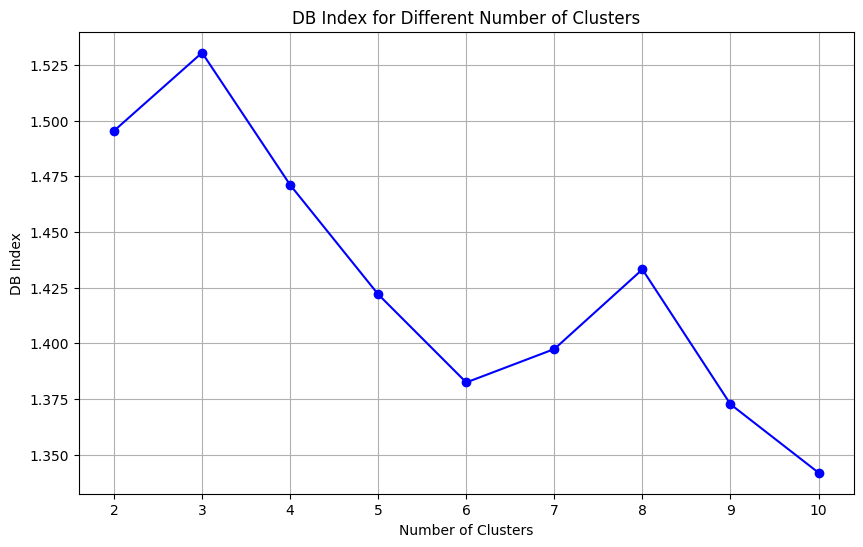

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_indexes, marker='o', linestyle='-', color='b')
plt.title("DB Index for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

##### The Lowest DB value is at 10 clusters, so number of clusters should be 10 but for now lets keep 4 since data is small

In [30]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(final_features)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### To viualize

In [31]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(final_features)

In [32]:
customer_profile['PCA1'] = pca_components[:, 0]
customer_profile['PCA2'] = pca_components[:, 1]

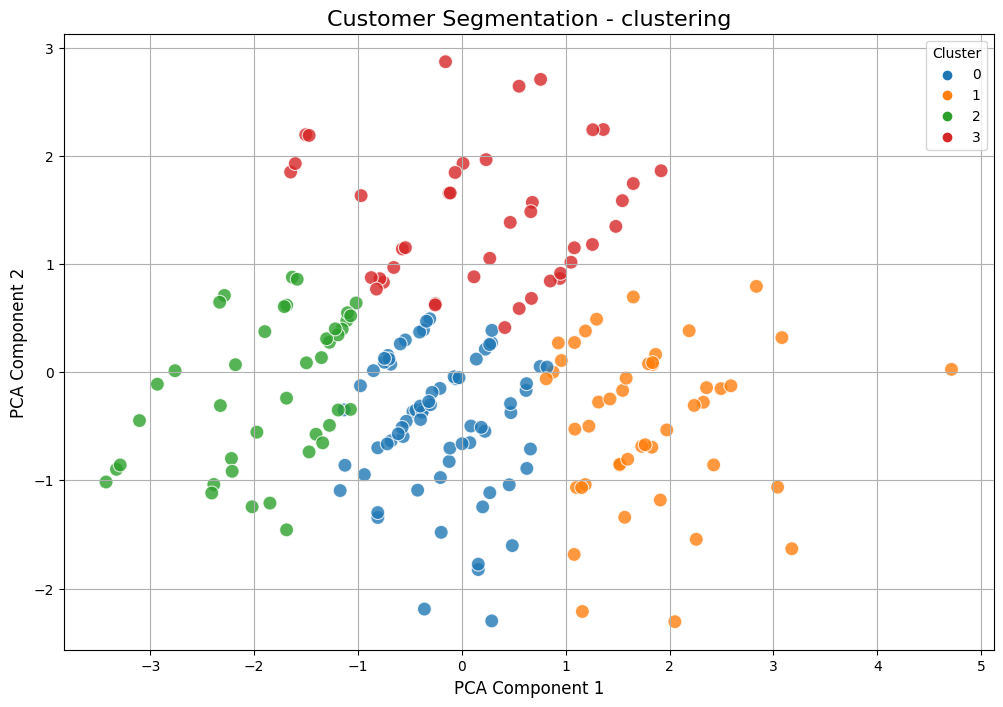

In [33]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=customer_profile['PCA1'], 
    y=customer_profile['PCA2'], 
    hue=customer_profile['Cluster'], 
    palette='tab10', 
    s=100, 
    alpha=0.8
)
plt.title("Customer Segmentation - clustering", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True)
plt.show()